In [1]:
import itertools
from pomps.policy_scope import PolicyComponent, MixedPolicyScope
from pomis.scm import *
import networkx as nx
from pomps.contextual_graphs import *
from pomps.policy_scope import *
from pomps.gp_fcm import *
from pomps.controllers import *
import pyro
import torch
from tqdm.auto import tqdm
import pyro.distributions as dist
from pomps.fcm import *

# from pomis.optimiser import CausalOptimiser, Objective, SCM
from pomis.scm import BoolDomain, SCM

In [2]:
def sampler_over():
    u1 = pyro.sample("U1", dist.Uniform(-1, 1))
    u2 = pyro.sample("U2", dist.Uniform(-1, 1))
    return {"U1": u1, "U2": u2}
fcm = FunctionalCausalModel({Functor(lambda U1: pyro.sample("C", dist.Normal(U1, 0.1)), 'C'),
                             Functor(lambda C, U1: pyro.sample("X1", dist.Normal(U1+C, 0.1)), 'X1'),
                             Functor(lambda C, X1, U2: pyro.sample("X2", dist.Normal(C+X1, torch.abs(U2))), 'X2'),
                             Functor(lambda U2, X2, C: pyro.sample("X2", 
                                        dist.Normal(torch.cos(C-X2)+U2/100, 0.01)), "Y")}, sampler_over)

# def model(count):
#     with pyro.plate("samples", count):
#         age = pyro.sample("age", dist.Uniform(55, 76))
#         bmi = pyro.sample("bmi", dist.Normal(27, 0.7))

#         aspirin_p = torch.sigmoid(-8.0 + 0.10 * age + 0.03 * bmi)
#         statin_p = torch.sigmoid(-13.0 + 0.10 * age + 0.20 * bmi)

#         aspirin = pyro.sample("aspirin", dist.Bernoulli(aspirin_p))
#         statin = pyro.sample("statin", dist.Bernoulli(statin_p))

#         cancer_p = torch.sigmoid(2.2 - 0.05 * age + 0.01 * bmi - 0.04 * statin + 0.02 * aspirin)
#         cancer = pyro.sample("cancer", dist.Bernoulli(cancer_p))

#         mean = 6.8 + 0.04 * age - 0.15 * bmi - 0.60 * statin + 0.55 * aspirin + 1.00 * cancer
#         y = pyro.sample("y", dist.Normal(mean, 0.4))
#     return y
# scm = SCM(model, [BoolDomain('aspirin'), BoolDomain('statin')], non_man={'age', 'bmi', 'cancer'})
# aspirin_graph = scm.induced_graph()
# ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"aspirin", "statin"}, 
#                       contextual_variables={"age", "bmi"}, target='y')
# ccg = MPSDAGController.simplify(ccg)

In [3]:
sum([fcm.sample()["Y"] for i in range(1000)])/1000

tensor(0.3770)

In [4]:
aspirin_graph = fcm.induced_graph()
ccg = ContextualCausalGraph(edges=aspirin_graph, interventional_variables={"X1", "X2"}, 
                      contextual_variables={"C", "X1"}, target='Y')
ccg = MPSDAGController.simplify(ccg)
space = [RealDomain("X1", -5, 5), RealDomain("X2", -5, 5), RealDomain("C", -5, 5)]
gpf = GPFunctorFactory(space)

In [5]:
ccg.interventional_variables, ccg.contextual_variables, ccg.uc_variables

({'X1', 'X2'}, {'C', 'X1'}, {'U1', 'U2'})

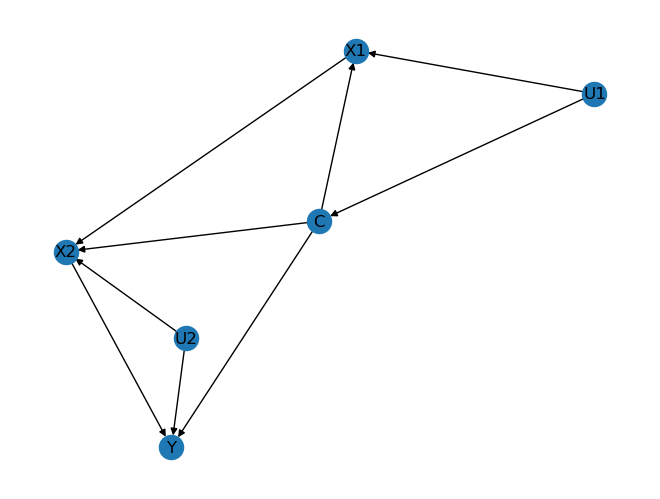

In [6]:
nx.draw(ccg, with_labels=True)

In [7]:
interventional_set = ccg.interventional_variables
contextual_set = ccg.contextual_variables

In [8]:
def all_combs(base, start=0):
    return list(itertools.chain(*[itertools.combinations(base, i) for i in range(start, len(base)+1)]))

def inter_cont_pair_gen(interventional_set, contextual_set):
    inter_segment = []
    context_space = all_combs(contextual_set)
    for inter in interventional_set:
        inter_segment += [[(inter, i) for i in context_space]]
    
    iam = all_combs(inter_segment)
    return itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], [])

def mpss(pair_gen):
    for mps_row in pair_gen:
        yield MixedPolicyScope({PolicyComponent(target, set(context))  for target, context in mps_row })

In [9]:
a = {1}
b = a
b = b | {2}

In [10]:
a, b

({1}, {1, 2})

In [11]:
mpses = list(mpss(inter_cont_pair_gen(interventional_set, contextual_set)))
print(len(mpses))
graph_under_mps = [(MPSDAGController.graph_under_mps(mps, ccg), mps) for mps in mpses]
print(len(graph_under_mps))

graph_under_mps = [(g[0][0], g[1]) for g in graph_under_mps if g[0][1]]
print(len(graph_under_mps))

graph_under_mps = [g for g in graph_under_mps if MPSReductor.action_relevance_check(g[1], g[0]) and MPSReductor.context_relevance_check(g[1], g[0])]
print(len(graph_under_mps))
graph_under_mps = [g for g in graph_under_mps if not MPSReductor.sufficiently_not_pomp(g[1], g[0])]
print(len(graph_under_mps))

25
25
15
set()
call
set()
call
set()
call
{'X1'}
call
{'C'}
call
set()
call
{'X1'} set()
{'X1', 'X2'} set()
{'X1', 'X2'} {'X1', 'X2'}
{'X1', 'X2'} {'X1', 'X2'}
{'X1'}
call
{'X1'} {'X1'}
{'C'}
call
{'C', 'X1'} {'C'}
{'C', 'X1', 'X2'} {'C'}
{'C', 'X1', 'X2'} {'C', 'X1', 'X2'}
{'C', 'X1', 'X2'} {'C', 'X1', 'X2'}
set()
call
set()
call
set()
call
{'X1'}
call
{'C'}
call
{'C', 'X1'} {'C'}
{'C', 'X1', 'X2'} {'C'}
{'C', 'X1', 'X2'} {'C', 'X1', 'X2'}
{'C', 'X1', 'X2'} {'C', 'X1', 'X2'}
7
set()
call
{'X1'} set()
{'X1'} {'X1'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
{'C'}
call
{'C', 'X2'} {'C'}
{'C', 'X2'} {'C', 'X2'}
{'X1'}
call
{'X1', 'X2'} {'X1'}
{'X1', 'X2'} {'X1', 'X2'}
{'X1'}
call
{'X1', 'X2'} {'X1'}
{'X1', 'X2'} {'X1', 'X2'}
3


In [12]:
graph_under_mps

[(<pomps.contextual_graphs.ContextualCausalGraph at 0x7fb7f9554f40>, ),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fb7f954f8b0>,
  <X1, {'C'}>),
 (<pomps.contextual_graphs.ContextualCausalGraph at 0x7fb7f954fac0>,
  <X2, {'C'}>)]

[{'C'}]


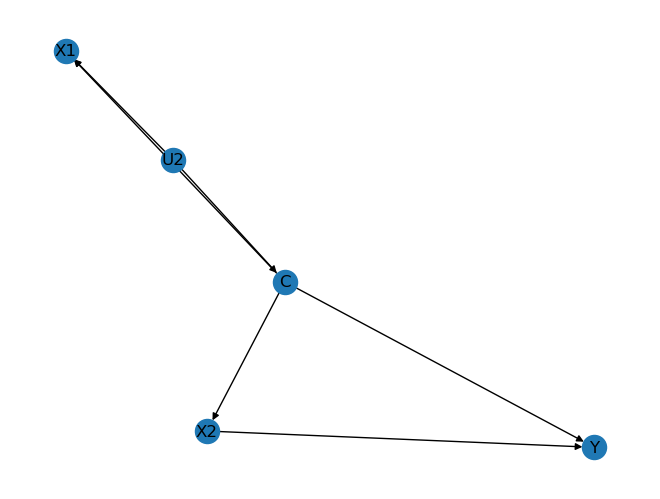

In [13]:
graph, mps = graph_under_mps[-1]
nx.draw(graph, with_labels=True)
is_single_gp = True
if is_single_gp:
    policy = PolicyFCM.mps_to_single_gp(mps, gpf)
else:
    policy = PolicyFCM.mps_to_gp_policy(mps, gpf)
fcm_m = PolicyFCM.fcm_with_policy(fcm, policy)

In [14]:
for i in tqdm(range(80)):
    smp = fcm_m.sample(necessary_context=mps.contextual_variables)
    y = smp[graph.target]
    y = torch.tensor([y])
    for p in policy:
        p.functional.observe(-y)
        if is_single_gp:
            break
    print(smp)
_ = fcm_m.sample()

  0%|          | 0/80 [00:00<?, ?it/s]

buffer {}
{'C': tensor(0.1175)} {'U1': tensor(0.0658), 'U2': tensor(-0.0169), 'C': tensor(0.1175), 'X1': tensor(0.1624)} {'C'} {'C'} X2
{'C': tensor(0.1175), 'X1': tensor(0.1624), 'X2': -5.0, 'Y': tensor(0.3845)}
buffer {}
{'C': tensor(0.9840)} {'U1': tensor(0.9666), 'U2': tensor(0.2312), 'C': tensor(0.9840), 'X1': tensor(1.8359)} {'C'} {'C'} X2
{'C': tensor(0.9840), 'X1': tensor(1.8359), 'X2': 0.0, 'Y': tensor(0.5606)}
buffer {}
{'C': tensor(-0.4994)} {'U1': tensor(-0.5085), 'U2': tensor(0.5496), 'C': tensor(-0.4994), 'X1': tensor(-1.1215)} {'C'} {'C'} X2
{'C': tensor(-0.4994), 'X1': tensor(-1.1215), 'X2': 2.5, 'Y': tensor(-0.9875)}
buffer {}
{'C': tensor(-0.6924)} {'U1': tensor(-0.7143), 'U2': tensor(-0.5465), 'C': tensor(-0.6924), 'X1': tensor(-1.5381)} {'C'} {'C'} X2
fitting GP
Eval optim           X2                C
0  -0.234936  tensor(-0.6924)
1   0.110742  tensor(-0.6924)
2  -0.174340  tensor(-0.6924)
3  -0.107691  tensor(-0.6924)
4  -0.252599  tensor(-0.6924)
5   0.000505  te

Eval optim           X2                C
0  -1.424463  tensor(-0.1664)
1  -1.176684  tensor(-0.1664)
2  -0.678782  tensor(-0.1664)
3  -1.159636  tensor(-0.1664)
4  -0.402405  tensor(-0.1664)
5  -0.436971  tensor(-0.1664)
6  -1.261536  tensor(-0.1664)
7  -0.328841  tensor(-0.1664)
8  -0.267536  tensor(-0.1664)
9  -0.825012  tensor(-0.1664)
11 -2.179089  tensor(-0.1664)
12 -0.881705  tensor(-0.1664)
13 -1.357380  tensor(-0.1664)
14 -1.819990  tensor(-0.1664)
15 -2.582771  tensor(-0.1664)
16 -0.484106  tensor(-0.1664)
17 -0.744412  tensor(-0.1664)
18 -1.295765  tensor(-0.1664)
19 -0.846214  tensor(-0.1664)
20 -0.690069  tensor(-0.1664)
22 -1.282114  tensor(-0.1664)
23 -0.852414  tensor(-0.1664)
24 -0.266442  tensor(-0.1664)
25 -0.269900  tensor(-0.1664)
26 -1.815577  tensor(-0.1664)
27 -0.577348  tensor(-0.1664)
28 -0.256236  tensor(-0.1664)
29 -0.700103  tensor(-0.1664)
30 -0.212279  tensor(-0.1664)
{'C': tensor(-0.1664), 'X1': tensor(-0.2417), 'X2': -0.328840741469776, 'Y': tensor(0.969

Eval optim           X2                C
0  -0.844921  tensor(-0.8217)
1   4.966764  tensor(-0.8217)
3  -0.560700  tensor(-0.8217)
4  -0.602818  tensor(-0.8217)
5  -0.749732  tensor(-0.8217)
6  -0.807652  tensor(-0.8217)
7  -0.636163  tensor(-0.8217)
8  -0.440823  tensor(-0.8217)
9   4.999542  tensor(-0.8217)
10  4.999417  tensor(-0.8217)
11  4.993841  tensor(-0.8217)
12 -0.560004  tensor(-0.8217)
13 -0.700163  tensor(-0.8217)
14  4.998088  tensor(-0.8217)
15  4.998037  tensor(-0.8217)
16  4.984579  tensor(-0.8217)
18 -0.616030  tensor(-0.8217)
19 -0.665071  tensor(-0.8217)
20  4.970288  tensor(-0.8217)
21 -0.554488  tensor(-0.8217)
22 -0.639791  tensor(-0.8217)
23 -0.743852  tensor(-0.8217)
24 -0.637162  tensor(-0.8217)
25 -0.637594  tensor(-0.8217)
{'C': tensor(-0.8217), 'X1': tensor(-1.6922), 'X2': -0.440823196199585, 'Y': tensor(0.9440)}
buffer {}
{'C': tensor(0.8548)} {'U1': tensor(0.6386), 'U2': tensor(-0.6364), 'C': tensor(0.8548), 'X1': tensor(1.7343)} {'C'} {'C'} X2
fitting GP

Eval optim           X2                C
0   4.336368  tensor(-0.4020)
1   3.944232  tensor(-0.4020)
2   4.086178  tensor(-0.4020)
3  -0.279805  tensor(-0.4020)
4  -0.336987  tensor(-0.4020)
5   4.076705  tensor(-0.4020)
6   4.387873  tensor(-0.4020)
7  -0.430061  tensor(-0.4020)
8   4.180723  tensor(-0.4020)
9   4.195028  tensor(-0.4020)
10  4.104509  tensor(-0.4020)
11 -0.360458  tensor(-0.4020)
13 -0.340127  tensor(-0.4020)
14 -0.289275  tensor(-0.4020)
15 -0.411101  tensor(-0.4020)
16 -0.464268  tensor(-0.4020)
{'C': tensor(-0.4020), 'X1': tensor(-0.7706), 'X2': -0.289274650075807, 'Y': tensor(0.9784)}
buffer {}
{'C': tensor(0.3144)} {'U1': tensor(0.3890), 'U2': tensor(-0.4299), 'C': tensor(0.3144), 'X1': tensor(0.5972)} {'C'} {'C'} X2
fitting GP
Eval optim          X2               C
0  0.413048  tensor(0.3144)
1  0.308821  tensor(0.3144)
2  0.276403  tensor(0.3144)
3  0.389253  tensor(0.3144)
4  0.308583  tensor(0.3144)
5  0.377337  tensor(0.3144)
6  0.389404  tensor(0.3144)
7  0

Eval optim           X2                C
0  -2.871839  tensor(-1.0143)
1  -2.984709  tensor(-1.0143)
2  -2.829303  tensor(-1.0143)
3  -2.812765  tensor(-1.0143)
4  -0.778760  tensor(-1.0143)
5  -2.740111  tensor(-1.0143)
6  -2.986859  tensor(-1.0143)
7  -2.571952  tensor(-1.0143)
8   4.999958  tensor(-1.0143)
9   4.998086  tensor(-1.0143)
11 -2.805231  tensor(-1.0143)
12  4.997635  tensor(-1.0143)
13  4.943159  tensor(-1.0143)
14 -0.906929  tensor(-1.0143)
15  4.993966  tensor(-1.0143)
16 -2.940284  tensor(-1.0143)
17 -2.721462  tensor(-1.0143)
18  4.809152  tensor(-1.0143)
19 -2.793665  tensor(-1.0143)
20  4.787505  tensor(-1.0143)
21 -2.774111  tensor(-1.0143)
22  4.865189  tensor(-1.0143)
23 -0.639722  tensor(-1.0143)
24 -0.660696  tensor(-1.0143)
25  4.999616  tensor(-1.0143)
{'C': tensor(-1.0143), 'X1': tensor(-1.8563), 'X2': 4.809152376984092, 'Y': tensor(0.8912)}
buffer {}
{'C': tensor(0.0245)} {'U1': tensor(0.0636), 'U2': tensor(0.9277), 'C': tensor(0.0245), 'X1': tensor(-0.047

Eval optim          X2               C
0  0.624251  tensor(0.5625)
1  0.610560  tensor(0.5625)
2  0.575838  tensor(0.5625)
3  0.644982  tensor(0.5625)
4  0.620477  tensor(0.5625)
7  0.608216  tensor(0.5625)
{'C': tensor(0.5625), 'X1': tensor(1.1965), 'X2': 0.6204767243380309, 'Y': tensor(0.9921)}
buffer {}
{'C': tensor(-0.5021)} {'U1': tensor(-0.3852), 'U2': tensor(-0.2765), 'C': tensor(-0.5021), 'X1': tensor(-0.8825)} {'C'} {'C'} X2
fitting GP
Eval optim           X2                C
0  -0.336841  tensor(-0.5021)
1  -0.531023  tensor(-0.5021)
2  -0.554645  tensor(-0.5021)
3  -0.425154  tensor(-0.5021)
4  -0.565093  tensor(-0.5021)
5  -0.511384  tensor(-0.5021)
6  -0.401710  tensor(-0.5021)
7  -0.985685  tensor(-0.5021)
8  -0.646975  tensor(-0.5021)
9  -0.458488  tensor(-0.5021)
10 -1.124009  tensor(-0.5021)
11 -0.427501  tensor(-0.5021)
12 -0.439489  tensor(-0.5021)
{'C': tensor(-0.5021), 'X1': tensor(-0.8825), 'X2': -0.42750149432634044, 'Y': tensor(0.9886)}
buffer {}
{'C': tensor(-0

Eval optim           X2                C
0   3.244442  tensor(-0.9687)
1  -0.878465  tensor(-0.9687)
2  -0.836614  tensor(-0.9687)
3  -0.753290  tensor(-0.9687)
4   3.318042  tensor(-0.9687)
5   3.361054  tensor(-0.9687)
6   3.310098  tensor(-0.9687)
7  -0.877839  tensor(-0.9687)
8  -0.878084  tensor(-0.9687)
9  -0.899465  tensor(-0.9687)
10  3.250810  tensor(-0.9687)
11  3.351549  tensor(-0.9687)
12 -0.812700  tensor(-0.9687)
13 -0.663437  tensor(-0.9687)
14 -0.878080  tensor(-0.9687)
16  3.378386  tensor(-0.9687)
17  3.428076  tensor(-0.9687)
18  3.378344  tensor(-0.9687)
{'C': tensor(-0.9687), 'X1': tensor(-1.9020), 'X2': 3.2508100131756548, 'Y': tensor(-0.4807)}
buffer {}
{'C': tensor(0.7225)} {'U1': tensor(0.5255), 'U2': tensor(0.4049), 'C': tensor(0.7225), 'X1': tensor(1.2056)} {'C'} {'C'} X2
fitting GP
Eval optim           X2               C
0   0.589643  tensor(0.7225)
1   0.551915  tensor(0.7225)
2   0.671072  tensor(0.7225)
3   0.678341  tensor(0.7225)
4   0.820360  tensor(0.

In [14]:
fcm_m.functors['X1'].functional.optimizer.best_x

,X1,C
77,-0.22741,tensor(-0.2812)


In [24]:
sum([fcm_m.sample()["Y"] for i in range(1000)])/1000

buffer {}
{'C': tensor(0.3349)} {'U1': tensor(0.3719), 'U2': tensor(0.7512), 'C': tensor(0.3349)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7771)} {'U1': tensor(0.7568), 'U2': tensor(0.8532), 'C': tensor(0.7771)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0657)} {'U1': tensor(-0.0564), 'U2': tensor(0.7644), 'C': tensor(-0.0657)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4529)} {'U1': tensor(-0.5128), 'U2': tensor(-0.6284), 'C': tensor(-0.4529)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5106)} {'U1': tensor(-0.4139), 'U2': tensor(0.7545), 'C': tensor(-0.5106)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8877)} {'U1': tensor(-0.7459), 'U2': tensor(0.3416), 'C': tensor(-0.8877)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1970)} {'U1': tensor(-0.4769), 'U2': tensor(0.4977), 'C': tensor(-0.1970)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4069)} {'U1': tensor(0.1989), 'U2': tensor(0.1013), 'C': tensor(0.4069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8208)} {'U1': tensor(0.8586), 'U2': tensor(0.4828), 'C'

buffer {}
{'C': tensor(-0.0826)} {'U1': tensor(-0.1725), 'U2': tensor(-0.2601), 'C': tensor(-0.0826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7305)} {'U1': tensor(-0.7769), 'U2': tensor(0.8565), 'C': tensor(-0.7305)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2101)} {'U1': tensor(0.1865), 'U2': tensor(0.7967), 'C': tensor(0.2101)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8682)} {'U1': tensor(-0.8046), 'U2': tensor(0.8763), 'C': tensor(-0.8682)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8163)} {'U1': tensor(0.7040), 'U2': tensor(0.7685), 'C': tensor(0.8163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(1.1254)} {'U1': tensor(0.9448), 'U2': tensor(-0.6513), 'C': tensor(1.1254)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5405)} {'U1': tensor(0.3392), 'U2': tensor(-0.0293), 'C': tensor(0.5405)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0810)} {'U1': tensor(0.1673), 'U2': tensor(-0.9943), 'C': tensor(0.0810)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4630)} {'U1': tensor(-0.3076), 'U2': tensor(0.3345), 'C':

buffer {}
{'C': tensor(-0.8831)} {'U1': tensor(-0.9199), 'U2': tensor(0.2879), 'C': tensor(-0.8831)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8514)} {'U1': tensor(0.9622), 'U2': tensor(-0.9442), 'C': tensor(0.8514)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4965)} {'U1': tensor(0.3669), 'U2': tensor(-0.6430), 'C': tensor(0.4965)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5541)} {'U1': tensor(0.4135), 'U2': tensor(-0.5419), 'C': tensor(0.5541)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0034)} {'U1': tensor(-0.0057), 'U2': tensor(-0.2678), 'C': tensor(0.0034)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1918)} {'U1': tensor(0.2384), 'U2': tensor(-0.2486), 'C': tensor(0.1918)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7709)} {'U1': tensor(-0.7085), 'U2': tensor(-0.3898), 'C': tensor(-0.7709)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9593)} {'U1': tensor(-0.9224), 'U2': tensor(-0.1760), 'C': tensor(-0.9593)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8826)} {'U1': tensor(-0.7230), 'U2': tensor(0.1477), 

buffer {}
{'C': tensor(0.5760)} {'U1': tensor(0.5169), 'U2': tensor(0.5109), 'C': tensor(0.5760)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8842)} {'U1': tensor(0.8401), 'U2': tensor(-0.7519), 'C': tensor(0.8842)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.9440)} {'U1': tensor(0.8113), 'U2': tensor(0.2589), 'C': tensor(0.9440)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6413)} {'U1': tensor(0.4306), 'U2': tensor(-0.7571), 'C': tensor(0.6413)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3826)} {'U1': tensor(0.4504), 'U2': tensor(0.8981), 'C': tensor(0.3826)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7998)} {'U1': tensor(-0.8659), 'U2': tensor(-0.1180), 'C': tensor(-0.7998)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5297)} {'U1': tensor(0.5546), 'U2': tensor(0.5995), 'C': tensor(0.5297)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0143)} {'U1': tensor(-0.0347), 'U2': tensor(0.8202), 'C': tensor(-0.0143)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4345)} {'U1': tensor(0.4569), 'U2': tensor(0.7620), 'C': tenso

buffer {}
{'C': tensor(-0.1189)} {'U1': tensor(-0.0938), 'U2': tensor(0.0194), 'C': tensor(-0.1189)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6137)} {'U1': tensor(-0.6591), 'U2': tensor(-0.2989), 'C': tensor(-0.6137)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0524)} {'U1': tensor(-0.0660), 'U2': tensor(-0.5848), 'C': tensor(-0.0524)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5177)} {'U1': tensor(-0.6928), 'U2': tensor(-0.7024), 'C': tensor(-0.5177)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5313)} {'U1': tensor(-0.5620), 'U2': tensor(-0.8155), 'C': tensor(-0.5313)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1454)} {'U1': tensor(-0.0175), 'U2': tensor(0.0422), 'C': tensor(0.1454)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5630)} {'U1': tensor(-0.6514), 'U2': tensor(-0.4816), 'C': tensor(-0.5630)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3591)} {'U1': tensor(0.3934), 'U2': tensor(-0.8009), 'C': tensor(0.3591)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4661)} {'U1': tensor(-0.5258), 'U2': tensor(-

buffer {}
{'C': tensor(0.9043)} {'U1': tensor(0.8370), 'U2': tensor(0.2800), 'C': tensor(0.9043)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4979)} {'U1': tensor(-0.5933), 'U2': tensor(-0.6975), 'C': tensor(-0.4979)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1955)} {'U1': tensor(0.3159), 'U2': tensor(0.1914), 'C': tensor(0.1955)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8228)} {'U1': tensor(0.8365), 'U2': tensor(-0.8311), 'C': tensor(0.8228)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1452)} {'U1': tensor(0.0165), 'U2': tensor(0.4228), 'C': tensor(0.1452)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6527)} {'U1': tensor(0.6728), 'U2': tensor(-0.0269), 'C': tensor(0.6527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7418)} {'U1': tensor(0.8572), 'U2': tensor(0.5438), 'C': tensor(0.7418)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.1149)} {'U1': tensor(-0.9314), 'U2': tensor(-0.2623), 'C': tensor(-1.1149)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3576)} {'U1': tensor(-0.4068), 'U2': tensor(0.4516), 'C': te

buffer {}
{'C': tensor(-0.2605)} {'U1': tensor(-0.1974), 'U2': tensor(0.6820), 'C': tensor(-0.2605)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7080)} {'U1': tensor(-0.6539), 'U2': tensor(-0.5800), 'C': tensor(-0.7080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1962)} {'U1': tensor(-0.1209), 'U2': tensor(-0.6859), 'C': tensor(-0.1962)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3317)} {'U1': tensor(-0.3432), 'U2': tensor(0.9108), 'C': tensor(-0.3317)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5358)} {'U1': tensor(0.6242), 'U2': tensor(-0.2945), 'C': tensor(0.5358)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4936)} {'U1': tensor(-0.5909), 'U2': tensor(0.0204), 'C': tensor(-0.4936)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8006)} {'U1': tensor(-0.7364), 'U2': tensor(0.6268), 'C': tensor(-0.8006)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4201)} {'U1': tensor(0.4380), 'U2': tensor(-0.8074), 'C': tensor(0.4201)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3488)} {'U1': tensor(-0.4807), 'U2': tensor(0.20

buffer {}
{'C': tensor(0.8632)} {'U1': tensor(0.8400), 'U2': tensor(-0.3019), 'C': tensor(0.8632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5471)} {'U1': tensor(0.5901), 'U2': tensor(0.4975), 'C': tensor(0.5471)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4346)} {'U1': tensor(-0.3862), 'U2': tensor(-0.3856), 'C': tensor(-0.4346)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1115)} {'U1': tensor(0.0449), 'U2': tensor(-0.0992), 'C': tensor(-0.1115)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8716)} {'U1': tensor(-0.8064), 'U2': tensor(0.1268), 'C': tensor(-0.8716)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4199)} {'U1': tensor(-0.4835), 'U2': tensor(0.9957), 'C': tensor(-0.4199)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0742)} {'U1': tensor(-0.0154), 'U2': tensor(-0.1419), 'C': tensor(-0.0742)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2648)} {'U1': tensor(0.2363), 'U2': tensor(0.5823), 'C': tensor(0.2648)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2307)} {'U1': tensor(-0.1762), 'U2': tensor(0.2684),

buffer {}
{'C': tensor(-0.7200)} {'U1': tensor(-0.7917), 'U2': tensor(0.8466), 'C': tensor(-0.7200)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4914)} {'U1': tensor(0.5409), 'U2': tensor(-0.5575), 'C': tensor(0.4914)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3602)} {'U1': tensor(-0.4817), 'U2': tensor(0.1817), 'C': tensor(-0.3602)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.8527)} {'U1': tensor(0.9669), 'U2': tensor(0.8734), 'C': tensor(0.8527)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2812)} {'U1': tensor(0.2954), 'U2': tensor(-0.5136), 'C': tensor(0.2812)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1320)} {'U1': tensor(-0.1157), 'U2': tensor(0.4703), 'C': tensor(-0.1320)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8327)} {'U1': tensor(-0.9343), 'U2': tensor(0.7960), 'C': tensor(-0.8327)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4639)} {'U1': tensor(0.4223), 'U2': tensor(0.1996), 'C': tensor(0.4639)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1517)} {'U1': tensor(0.1631), 'U2': tensor(0.7737), 'C': 

buffer {}
{'C': tensor(0.7163)} {'U1': tensor(0.7433), 'U2': tensor(0.1738), 'C': tensor(0.7163)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4338)} {'U1': tensor(0.5537), 'U2': tensor(0.4018), 'C': tensor(0.4338)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1834)} {'U1': tensor(-0.1808), 'U2': tensor(-0.4139), 'C': tensor(-0.1834)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2210)} {'U1': tensor(0.1760), 'U2': tensor(-0.3728), 'C': tensor(0.2210)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2724)} {'U1': tensor(0.1958), 'U2': tensor(-0.3086), 'C': tensor(0.2724)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0632)} {'U1': tensor(-0.0409), 'U2': tensor(-0.3894), 'C': tensor(-0.0632)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5110)} {'U1': tensor(0.6527), 'U2': tensor(-0.9544), 'C': tensor(0.5110)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1151)} {'U1': tensor(-0.0863), 'U2': tensor(0.8031), 'C': tensor(-0.1151)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0386)} {'U1': tensor(-0.9930), 'U2': tensor(-0.3480), 'C

buffer {}
{'C': tensor(-0.6770)} {'U1': tensor(-0.7848), 'U2': tensor(0.7386), 'C': tensor(-0.6770)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2808)} {'U1': tensor(0.3138), 'U2': tensor(-0.9476), 'C': tensor(0.2808)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.0668)} {'U1': tensor(0.1259), 'U2': tensor(-0.4100), 'C': tensor(0.0668)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3069)} {'U1': tensor(-0.1921), 'U2': tensor(0.5152), 'C': tensor(-0.3069)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4478)} {'U1': tensor(0.3611), 'U2': tensor(0.3289), 'C': tensor(0.4478)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.6927)} {'U1': tensor(-0.8606), 'U2': tensor(-0.6609), 'C': tensor(-0.6927)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1773)} {'U1': tensor(0.2386), 'U2': tensor(-0.4545), 'C': tensor(0.1773)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1060)} {'U1': tensor(-0.2210), 'U2': tensor(-0.7924), 'C': tensor(-0.1060)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.0553)} {'U1': tensor(-0.1733), 'U2': tensor(0.2183), 

buffer {}
{'C': tensor(-0.3746)} {'U1': tensor(-0.4899), 'U2': tensor(0.5303), 'C': tensor(-0.3746)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1851)} {'U1': tensor(0.1951), 'U2': tensor(0.6746), 'C': tensor(0.1851)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5059)} {'U1': tensor(0.5822), 'U2': tensor(-0.6482), 'C': tensor(0.5059)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.8479)} {'U1': tensor(-0.7988), 'U2': tensor(-0.7120), 'C': tensor(-0.8479)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4502)} {'U1': tensor(0.4586), 'U2': tensor(0.4371), 'C': tensor(0.4502)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3096)} {'U1': tensor(-0.4339), 'U2': tensor(0.3793), 'C': tensor(-0.3096)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-1.0461)} {'U1': tensor(-0.9740), 'U2': tensor(0.9017), 'C': tensor(-1.0461)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.3604)} {'U1': tensor(0.1088), 'U2': tensor(0.0483), 'C': tensor(0.3604)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.4458)} {'U1': tensor(-0.4618), 'U2': tensor(0.5717), 'C'

buffer {}
{'C': tensor(0.9711)} {'U1': tensor(0.9691), 'U2': tensor(-0.2759), 'C': tensor(0.9711)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.3080)} {'U1': tensor(-0.2169), 'U2': tensor(-0.0886), 'C': tensor(-0.3080)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.1525)} {'U1': tensor(-0.0877), 'U2': tensor(-0.4516), 'C': tensor(-0.1525)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5952)} {'U1': tensor(-0.4424), 'U2': tensor(0.3671), 'C': tensor(-0.5952)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.2978)} {'U1': tensor(-0.4826), 'U2': tensor(0.6547), 'C': tensor(-0.2978)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9360)} {'U1': tensor(-0.9212), 'U2': tensor(-0.2856), 'C': tensor(-0.9360)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7938)} {'U1': tensor(-0.8422), 'U2': tensor(-0.9802), 'C': tensor(-0.7938)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.7554)} {'U1': tensor(0.7457), 'U2': tensor(-0.3465), 'C': tensor(0.7554)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.2671)} {'U1': tensor(0.3315), 'U2': tensor(-0.6

buffer {}
{'C': tensor(-0.6224)} {'U1': tensor(-0.6409), 'U2': tensor(-0.1234), 'C': tensor(-0.6224)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.5573)} {'U1': tensor(-0.6019), 'U2': tensor(0.5680), 'C': tensor(-0.5573)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.7920)} {'U1': tensor(-0.7927), 'U2': tensor(-0.7087), 'C': tensor(-0.7920)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1150)} {'U1': tensor(0.1502), 'U2': tensor(0.8838), 'C': tensor(0.1150)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.1073)} {'U1': tensor(-0.0371), 'U2': tensor(0.3344), 'C': tensor(0.1073)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.4883)} {'U1': tensor(0.5051), 'U2': tensor(0.9682), 'C': tensor(0.4883)} {'C'} {'C'} X1
buffer {}
{'C': tensor(-0.9867)} {'U1': tensor(-0.9137), 'U2': tensor(-0.5154), 'C': tensor(-0.9867)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.5191)} {'U1': tensor(0.3431), 'U2': tensor(-0.6637), 'C': tensor(0.5191)} {'C'} {'C'} X1
buffer {}
{'C': tensor(0.6618)} {'U1': tensor(0.4974), 'U2': tensor(0.2298), 'C

tensor(0.8081)

In [18]:
g = graph_under_mps[-2]
print(g[1])
MPSReductor.sufficiently_not_pomp(g[1], g[0])

<X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}


False

In [27]:
g[0].uc_variables

{'U1'}

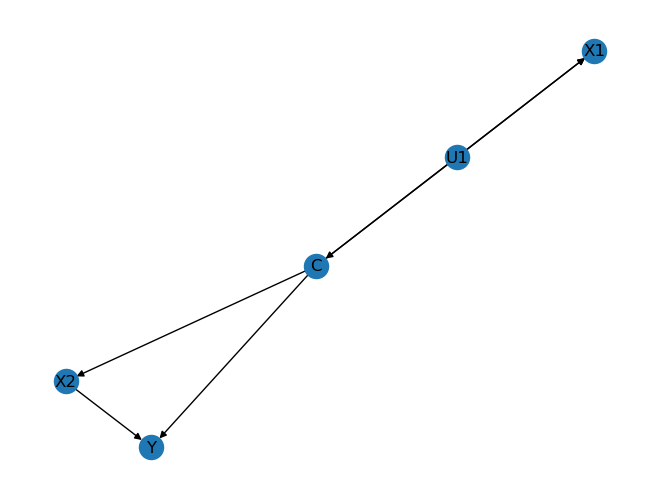

In [28]:
nx.draw(g[0], with_labels=True)

In [15]:
for idx, g in enumerate(graph_under_mps):
    print(idx, g[1])
    MPSReductor.sufficiently_not_pomp(g[1], g[0])

0 
1 <X2, set()>
set()
call
{'X2'} set()
{'X2'} {'X2'}
set()
call
{'X2'} set()
{'X2'} {'X2'}
2 <X2, {'C'}>
{'C'}
call
{'X2', 'C'} {'C'}
{'X2', 'C'} {'X2', 'C'}
3 <X2, {'X1'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}
4 <X1, set()>
set()
call
{'X1'} set()
{'X1'} {'X1'}
5 <X1, {'C'}>
6 <X2, {'X1'}>	<X1, {'C'}>
{'X1'}
call
{'X2', 'X1'} {'X1'}
{'X2', 'X1'} {'X2', 'X1'}


In [10]:
mps = MixedPolicyScope(dict())
MPSDAGController.graph_under_mps(mps, ccg), mps

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7f8e610e3130>, True), )

In [8]:
g = graph_under_mps[0]
MPSReductor.sufficiently_not_pomp(g[1], g[0][0])

False

In [9]:
g

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fed29561520>, True),
 <statin, set()>)

In [16]:
graph_under_mps[1]

((<pomps.contextual_graphs.ContextualCausalGraph at 0x7fcde0cb9580>, True),
 <aspirin, {'age'}>)

In [18]:
MPSReductor.action_relevance_check(graph_under_mps[0][1], graph_under_mps[0][0][0])

True

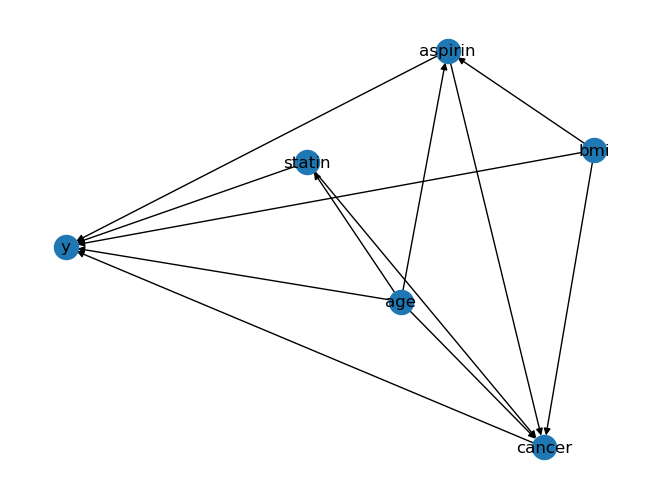

In [36]:
nx.draw(graph_under_mps[i][0], with_labels=True)

In [96]:
inter_segment = []
for inter in interventional_set:
    inter_segment += [[(inter, i) for i in contexts]]

In [104]:
iam = all_combs(inter_segment)
list(itertools.chain(*[(itertools.product(*iam[i])) for i in range(len(iam))], []))

[(),
 (('X1', ()),),
 (('X1', ('C2',)),),
 (('X1', ('C1',)),),
 (('X1', ('C2', 'C1')),),
 (('X2', ()),),
 (('X2', ('C2',)),),
 (('X2', ('C1',)),),
 (('X2', ('C2', 'C1')),),
 (('X1', ()), ('X2', ())),
 (('X1', ()), ('X2', ('C2',))),
 (('X1', ()), ('X2', ('C1',))),
 (('X1', ()), ('X2', ('C2', 'C1'))),
 (('X1', ('C2',)), ('X2', ())),
 (('X1', ('C2',)), ('X2', ('C2',))),
 (('X1', ('C2',)), ('X2', ('C1',))),
 (('X1', ('C2',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C1',)), ('X2', ())),
 (('X1', ('C1',)), ('X2', ('C2',))),
 (('X1', ('C1',)), ('X2', ('C1',))),
 (('X1', ('C1',)), ('X2', ('C2', 'C1'))),
 (('X1', ('C2', 'C1')), ('X2', ())),
 (('X1', ('C2', 'C1')), ('X2', ('C2',))),
 (('X1', ('C2', 'C1')), ('X2', ('C1',))),
 (('X1', ('C2', 'C1')), ('X2', ('C2', 'C1')))]

In [100]:
list(itertools.product(interventional_set, contexts))

[('X1', ()),
 ('X1', ('C2',)),
 ('X1', ('C1',)),
 ('X1', ('C2', 'C1')),
 ('X2', ()),
 ('X2', ('C2',)),
 ('X2', ('C1',)),
 ('X2', ('C2', 'C1'))]